# Trabajo Práctico 1

In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


 # Glosario columnas

-  operation: tipo de operacion (venta)
-  property type: tipo de propiedad (house, PH, apartment, store)
-  place_name: localidad de la propiedad.
-  place_with_parent_names: localidad junto a provinca, pais.
-  country_name: pais donde se encuentra la propiedad.
-  state_name: provincia donde se encuentra la propiedad.
-  geonames_id: número de identificación en la base de datos GeoNames.
-  lat-lon: latitud y longitud juntos.
-  lat: latidud.
-  lon: longitud.
-  price: precio de la propiedad en relacion a su moneda.
-  currency: moneda en la que se encuentra valorizada la propiedad.
-  price_aprox_local_currency: precio aproximado en pesos de la propiedad.
-  price_aprox_usd: precio aproximado del inmueble en dólares.
-  surface_total_in_m2: superficie total del inmueble en metros cuadrados.
-  surface_covered_in_m2: superficie cubierta del inmueble en metros cuadrados.
-  price_usd_per_m2: precio en dólares del metro cuadrado vs total m2.
-  price_per_m2: precio, no se sabe en qué moneda.
-  floor: piso? no es claro, valores extraños.
-  rooms: cantidad de habitaciones.
-  expenses: valor de las expensas.
-  properati_url: url de la url de properati donde está publicado el inmueble.
-  description: descripción completa de todo el inmueble. Contiene información de todas las columnas y más.
-  title: título con el que se encuentra publicado. Aparece el tipo de propiedad, zona y alguna característica destacada como cantidad de ambientes.
-  image_thumbnail: fotos del inmueble.

# Leemos el dataset

In [125]:
data=pd.read_csv('./properatti.csv')

# Observamos las diferentes columnas, los tipos de datos y cuantos valores no nulos tienen


In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

In [127]:
#El metodo describe arroja principalmente estadisticas descriptivas para columnas con datos cuantitativos, es por ello que vemos tan solo 14 columnas del dataset
data.describe()

,Unnamed: 0,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,121220.000000,1.025030e+05,69670.000000,69670.000000,1.008100e+05,1.008100e+05,1.008100e+05,81892.000000,101313.000000,68617.000000,8.765800e+04,7899.000000,47390.000000,1.426200e+04
mean,60609.500000,3.574442e+06,-34.626210,-59.266290,4.685259e+05,4.229397e+06,2.397006e+05,233.795328,133.050181,2160.086916,6.912216e+03,17.452336,3.080840,5.009234e+03
std,34993.344153,3.541306e+05,1.980936,2.299922,2.260101e+06,6.904714e+06,3.913239e+05,1782.222147,724.351479,2759.288621,2.837864e+04,120.243621,1.860773,1.204403e+05
min,0.000000,3.427208e+06,-54.823985,-75.678931,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.600000,1.510204e+00,1.000000,1.000000,1.000000e+00
25%,30304.750000,3.430234e+06,-34.669065,-58.727040,1.100000e+05,1.583309e+06,8.973388e+04,50.000000,45.000000,1218.181818,1.550000e+03,1.000000,2.000000,1.000000e+03
50%,60609.500000,3.433910e+06,-34.597985,-58.480128,1.850000e+05,2.558452e+06,1.450000e+05,84.000000,75.000000,1800.000000,2.213115e+03,3.000000,3.000000,2.000000e+03
75%,90914.250000,3.836668e+06,-34.441299,-58.395908,4.200000e+05,4.675792e+06,2.650000e+05,200.000000,150.000000,2486.411765,3.355549e+03,6.000000,4.000000,4.000000e+03
max,121219.000000,6.948895e+06,4.545843,-53.733330,6.500000e+08,8.212711e+08,4.654544e+07,200000.000000,187000.000000,206333.333333,4.000000e+06,3150.000000,32.000000,1.000150e+07


In [128]:
#Tomamos una muestra para entender los valores del dataset
data.sample(10)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
79376,79376,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,NaN,NaN,...,129.0,3205.128205,3875.968992,NaN,NaN,9091.0,http://www.properati.com.ar/1avgl_venta_depart...,Duplex en venta de 3 dormitorios con depend...,Duplex en venta de 3 dormitorios con depend...,https://thumbs4.properati.com/0/0LjGeqQrYHv0rp...
37080,37080,sell,house,Villa Luzuriaga,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,Argentina,Bs.As. G.B.A. Zona Oeste,3427406.0,NaN,NaN,...,121.0,NaN,NaN,NaN,3.0,NaN,http://www.properati.com.ar/18ias_venta_casa_v...,Casa americana de 3 ambientes a modernizar sob...,Casa en Venta Villa Luzuriaga / La Matanza (A...,https://thumbs4.properati.com/2/5lIQiOTdPOey5C...
68815,68815,sell,apartment,Nuñez,|Argentina|Capital Federal|Nuñez|,Argentina,Capital Federal,3430348.0,"-34.5434286003,-58.4612632997",-34.543429,...,71.0,4487.179487,4929.577465,NaN,NaN,3600.0,http://www.properati.com.ar/1aheq_venta_depart...,Visite esta propiedad en y vea la zona en Goo...,"Increible vista al Rìo y amenities premium, co...",https://thumbs4.properati.com/7/cDf7jfm4upDwhN...
102881,102881,sell,house,Merlo,|Argentina|San Luis|Merlo|,Argentina,San Luis,3844377.0,NaN,NaN,...,90.0,NaN,1666.666667,NaN,NaN,NaN,http://www.properati.com.ar/1br5j_venta_casa_m...,Dos plantas en excelente Ubicación (Nuevo Merl...,Casa - Venta- Nuevo Merlo,https://thumbs4.properati.com/9/UjpLn1gX90yf0H...
73369,73369,sell,apartment,Balvanera,|Argentina|Capital Federal|Balvanera|,Argentina,Capital Federal,6693228.0,"-34.6240062958,-58.4033550548",-34.624006,...,53.0,2452.830189,2452.830189,NaN,NaN,650.0,http://www.properati.com.ar/1anme_venta_depart...,Hermoso 2 ambientes de 53m2 a estrenar en una ...,Venta Departamento 2 Ambientes de 53m2 a estre...,https://thumbs4.properati.com/3/WFJNyjqv_GhvBD...
53573,53573,sell,house,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.9068942978,-60.6854827931",-32.906894,...,130.0,1266.666667,1461.538462,NaN,NaN,NaN,http://www.properati.com.ar/19lij_venta_casa_r...,"exelente inmueble resuelto en dos plantas, el ...",BARRIO ALBERDI,https://thumbs4.properati.com/7/DEdmVw5fg7fuWQ...
22541,22541,sell,apartment,San Nicolás,|Argentina|Capital Federal|San Nicolás|,Argentina,Capital Federal,6693229.0,"-34.6008675,-58.3925888",-34.600867,...,75.0,1510.344828,2920.000000,NaN,3.0,NaN,http://www.properati.com.ar/17j4p_venta_depart...,Duplex semipiso en PB de 3 ambientes con depen...,Viamonte 1800 San Nicolás 3amb U$219.000,https://thumbs4.properati.com/8/k5sWNUmSqUNNH5...
37002,37002,sell,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5620844,-58.4566864",-34.562084,...,75.0,3035.714286,3400.000000,NaN,3.0,NaN,http://www.properati.com.ar/18i5v_venta_depart...,Hermoso 3 amb al Frente a Estrenar de 88 m2 to...,3 amb C/ Cochera en Edificio Sustentable A Est...,https://thumbs4.properati.com/8/tXbIQfHIvgKb10...
59361,59361,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.9410577,-60.6479224",-32.941058,...,70.0,2000.000000,2000.000000,NaN,4.0,NaN,http://www.properati.com.ar/19x8q_venta_depart...,URQUIZA 1872Departamento de 2 dormitorios con ...,2 Dormitorios en pleno Centro,https://thumbs4.properati.com/2/O3UH0dEJxLrwqH...
97710,97710,sell,house,Santa María,|Argentina|Córdoba|Santa María|,Argentina,Córdoba,3836128.0,NaN,NaN,...,130.0,NaN,1076.923077,NaN,NaN,NaN,http://www.properati.com.ar/1bkh2_venta_casa_s...,Inmobiliaria Ruarte Moyano vende Moderna casa ...,Preciosa Casa APTA CRÉDITO - Barrio - Cámara,https://thumbs4.properati.com/7/fciA30wiCoj_wB...


# EDA (Exploration Data Analysis)

# Porcentaje por columna


In [129]:
#Porcentaje de nulls respecto al total del dataset por columna

percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
floor,floor,93.483749
expenses,expenses,88.234615
rooms,rooms,60.905791
price_usd_per_m2,price_usd_per_m2,43.394654
lat-lon,lat-lon,42.525986
lat,lat,42.525986
lon,lon,42.525986
surface_total_in_m2,surface_total_in_m2,32.443491
price_per_m2,price_per_m2,27.686850
currency,currency,16.837981


In [130]:
# Verificamos que todas las operaciones sean de tipo "Venta" // Podemos descartar esta columna
data.operation.value_counts()

sell    121220
Name: operation, dtype: int64

# Dropeamos (descartamos) la columna operation porque tiene un solo valor

In [131]:
data.drop('operation',inplace=True, axis=1)

# Property Type

apartment    71065
house        40268
PH            5751
store         4136
Name: property_type, dtype: int64


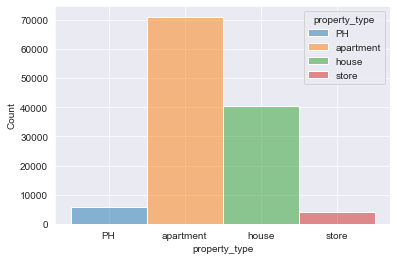

In [132]:
# Vemos 4 valores distintos de property_type. 
# La mayor cantidad de anuncios son de Apartment y House
print(data.property_type.value_counts())
sns.histplot( x="property_type", data=data, hue='property_type' )
plt.show()


In [133]:
# Valores de property_type
data.place_name.value_counts()

Córdoba               9254
Rosario               8504
Mar del Plata         6534
Tigre                 3324
Nordelta              3315
                      ... 
Sierras Bayas            1
Paso de los Libres       1
Azara                    1
Coronel Du Graty         1
Altos de Hudson I        1
Name: place_name, Length: 1060, dtype: int64

# Chequeamos si los valores de place_name coinciden con place_with_parent_names

In [134]:
# Chequeo si todos los place_names son correctos en place_with_parent_names
# 23 --> a 23 registros le falta el place name
place_coincide = data.apply(lambda x: True if str(x['place_with_parent_names']).find(str(x['place_name'])) >= 0 else False, axis=1)
place_coincide.value_counts()

True     121197
False        23
dtype: int64

In [135]:
#Los que faltan son todos de Tigre
data.place_name.isnull().value_counts()

False    121197
True         23
Name: place_name, dtype: int64

# Imputamos los valores diferentes por Tigre


In [136]:
#Imputamos los valores faltantes en place_name con el Valor de Tigre.
data['place_name'] = data['place_name'].replace('nan', 'Tigre')

#Chequeamos los valores
place_coincide = data.apply(lambda x: True if str(x['place_with_parent_names']).find(str(x['place_name'])) >= 0 else False, axis=1)
place_coincide.value_counts()

mask= place_coincide== False
data[mask]

data.iloc[6489]

Unnamed: 0                                                                 6489
property_type                                                             house
place_name                                                                  NaN
place_with_parent_names             |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
country_name                                                          Argentina
state_name                                             Bs.As. G.B.A. Zona Norte
geonames_id                                                                 NaN
lat-lon                                             -34.4008968545,-58.63809847
lat                                                                  -34.400897
lon                                                                  -58.638098
price                                                                  650000.0
currency                                                                    USD
price_aprox_local_currency              

In [137]:
#Hay nombres de place_name que tiene espacios al principio/final del string
data['place_name'] = data['place_name'].apply(lambda x : str(x).strip())

# Chequeamos si los valores de state_name coinciden con place_with_parent_names


In [138]:
# Chequeo si todos los state_names son correctos en place_with_parent_names.
# 121220 --> Todos OK 
state_coincide = data.apply(lambda x: True if str(x['place_with_parent_names']).find(str(x['state_name'])) >= 0 else False, axis=1)
state_coincide.value_counts()

True    121220
dtype: int64

In [139]:
# Chequeo si todos los country_names son correctos en place_with_parent_names
# 121220 --> Todos OK 
country_coincide = data.apply(lambda x: True if str(x['place_with_parent_names']).find(str(x['country_name'])) >= 0 else False, axis=1)
country_coincide.value_counts()

True    121220
dtype: int64

In [140]:
#Verificamos los diferentes valores de country_name
data['country_name'].value_counts()

Argentina    121220
Name: country_name, dtype: int64

# Dropeamos country_name

In [141]:
#Drop country_name porque tiene un solo valor
data.drop('country_name', inplace=True, axis=1)

# State Name

Capital Federal                 32316
Bs.As. G.B.A. Zona Norte        25560
Bs.As. G.B.A. Zona Sur          13952
Córdoba                         12069
Santa Fe                        10172
Buenos Aires Costa Atlántica    10006
Bs.As. G.B.A. Zona Oeste         9322
Buenos Aires Interior            2291
Río Negro                         808
Neuquén                           733
Name: state_name, dtype: int64


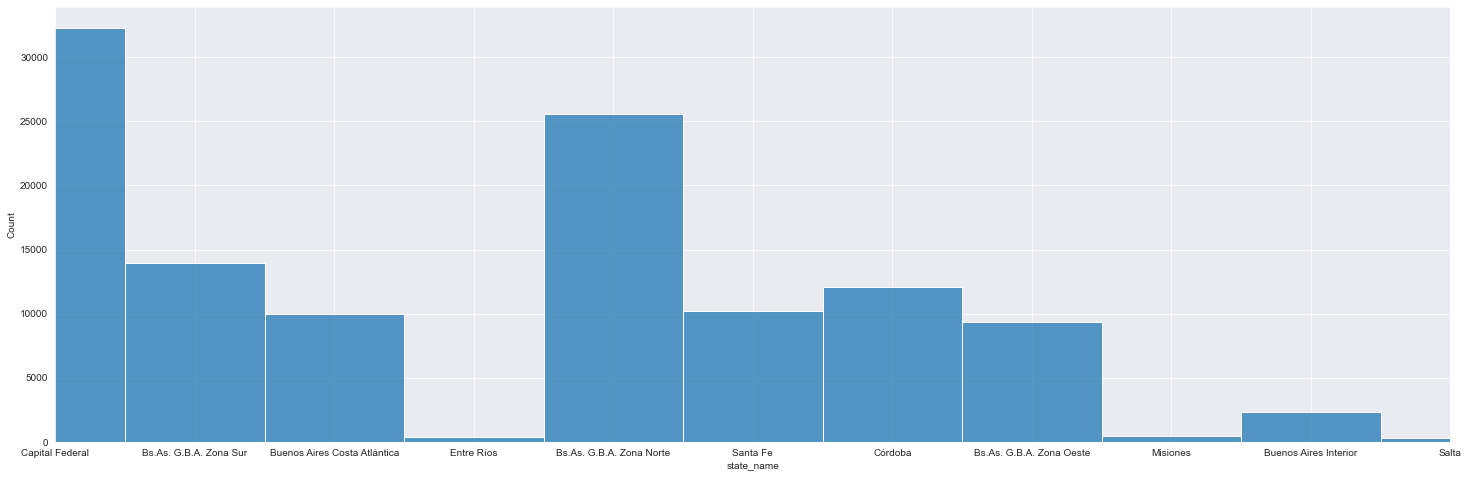

In [142]:
#Top 10 Provincias con mas propiedades
s= data.state_name.value_counts().nlargest(10)
print(s)
plt.figure(figsize=(25, 8))

#Histplot con propiedades por provincia
g =sns.histplot(x="state_name",  data=data)
g.set(xlim=(0,10))
plt.show()

# State Name // Group By

In [143]:
# Chequeo de la cantidad de publicaciones por state_name ordenada.

#data.columns
#data_grouped = data.groupby(['state_name'])
#display(data_grouped.describe().sort_values(by=('price_aprox_usd','count'), ascending=False)['price_aprox_usd'].round)
#data_grouped.describe().sort_values(by=('price_aprox_usd','count'), ascending=False)['price_aprox_usd'].round

# // Creo que lo de arriba puede ser reemplazable por la linea 9. Es mas prolijo y le agrega el valor de armarlo por property type.
# De todas maneras podriamos poner esto aparte ya que parece datos estadisticos y podria ir en otra seccion.

data.groupby(['state_name', 'property_type'])[['price_aprox_usd']].describe()



price_aprox_usd                 \
                                                 count           mean   
state_name               property_type                                  
Bs.As. G.B.A. Zona Norte PH                      978.0  136045.021789   
                         apartment              9936.0  201112.905033   
                         house                 12600.0  426326.612906   
                         store                   544.0  550360.608254   
Bs.As. G.B.A. Zona Oeste PH                      757.0  110474.792761   
...                                                ...            ...   
Tierra Del Fuego         store                     3.0  371514.630000   
Tucumán                  PH                        2.0   77675.885000   
                         apartment               140.0  133386.182071   
                         house                    61.0  218445.141803   
                         store                    10.0  168659.926000   

                                                                              \
                                                  std       min          25%   
state_name               property_type                                         
Bs.As. G.B.A. Zona Norte PH              68278.211861   5047.53   90000.0000   
                         apartment      175706.941832   5047.53  110000.0000   
                         house          422682.493543   5047.53  215000.0000   
                         store          976198.658582  14020.91   98750.0000   
Bs.As. G.B.A. Zona Oeste PH              68628.121968  14020.91   75000.0000   
...                                               ...       ...          ...   
Tierra Del Fuego         store          342156.549230  84125.51  182271.9450   
Tucumán                  PH              72572.582197  26359.32   52017.6025   
                         apartment      320598.012964  16719.77   60852.2400   
                         house          390074.332898  16916.52   72908.7700   
                         store          176861.139066   6383.89   45932.1475   

                                                                              
                                               50%          75%          max  
state_name               property_type                                        
Bs.As. G.B.A. Zona Norte PH             125000.000  165000.0000    680000.00  
                         apartment      155525.295  240000.0000   2550000.00  
                         house          328000.000  490000.0000  14000000.00  
                         store          250000.000  550000.0000  13000000.00  
Bs.As. G.B.A. Zona Oeste PH              98000.000  128000.0000    980000.00  
...                                            ...          ...          ...  
Tierra Del Fuego         store          280418.380  515209.1900    750000.00  
Tucumán                  PH              77675.885  103334.1675    128992.45  
                         apartment       84069.425  108606.0350   3300000.00  
                         house          112167.350  196292.8600   2500000.00  
                         store           91135.970  293668.1450    476711.25  

[98 rows x 8 columns]

# Currency

In [144]:
#Verificamos los valores de currency
data['currency'].value_counts()

USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

# Tipo de Cambio

In [145]:
#Verificamos el tipo de cambio y si el price_aprox_usd es correcto con respecto al price_aprox_local_currency

data["tipo_de_cambio"]=round(data.price_aprox_local_currency/data.price_aprox_usd,2)
print(f'Desvío tipo de cambio= ', data.tipo_de_cambio.std())
print(data['tipo_de_cambio'].value_counts())
print(f'Tipo de cambio nulos: ', data.tipo_de_cambio.isnull().sum())


Desvío tipo de cambio=  3.487005770896986e-11
17.64    100809
Name: tipo_de_cambio, dtype: int64
Tipo de cambio nulos:  20411


# Dropeamos columnas siguiendo criterio USD


In [146]:
#Dropeamos currency, price_aprox_local_currency y price_per_m2 para dejar solo las columnas por dolares
Esta bien esto ? Me parece que no
#data.drop(['currency','price_aprox_local_currency','price_per_m2'], inplace=True, axis=1)

SyntaxError: invalid syntax (1053208260.py, line 2)

# Analisis Estadistico Descriptivo

# Price Aprox USD

In [147]:
#Quartiles para graficar outliers de Price aprox USD
data['price_aprox_usd'].quantile([.95, .98, .99, .995, .998])


0.950     700000.00
0.980    1150000.00
0.990    1504888.49
0.995    2000000.00
0.998    2900000.00
Name: price_aprox_usd, dtype: float64

<AxesSubplot:xlabel='property_type', ylabel='price_aprox_usd'>

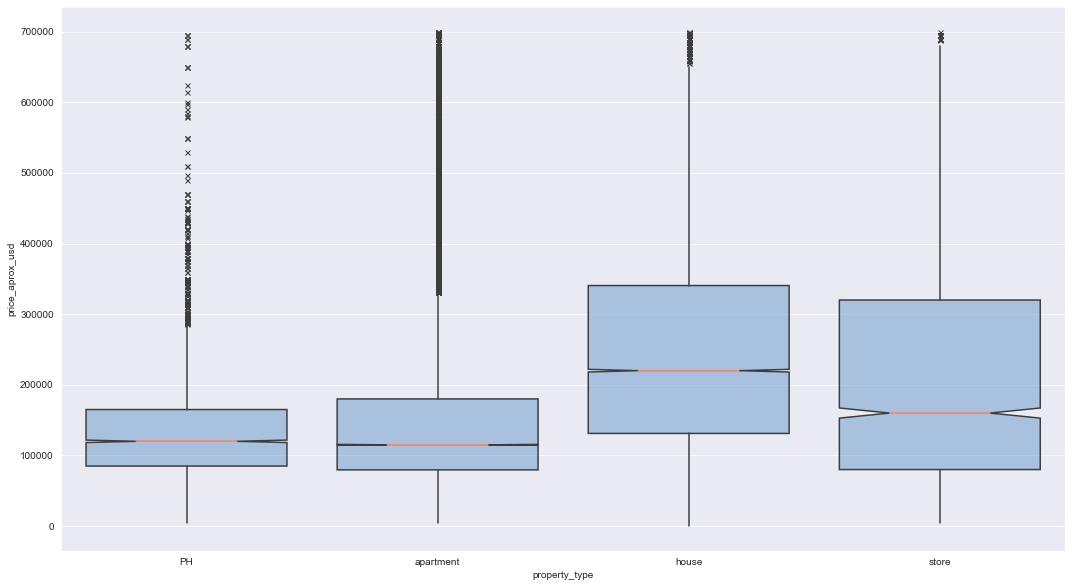

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(18, 10))
sns.boxplot(
    data=data, x="property_type", y=data[data['price_aprox_usd'] < 700000]['price_aprox_usd'],
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)


# Surface Aprox USD

In [151]:
#Quartiles para graficar surface total in m2
data['surface_total_in_m2'].quantile([.95, .98, .99, .995, .998])


0.950     704.450
0.980    1120.180
0.990    1700.000
0.995    2700.000
0.998    5732.924
Name: surface_total_in_m2, dtype: float64

<AxesSubplot:xlabel='property_type', ylabel='surface_total_in_m2'>

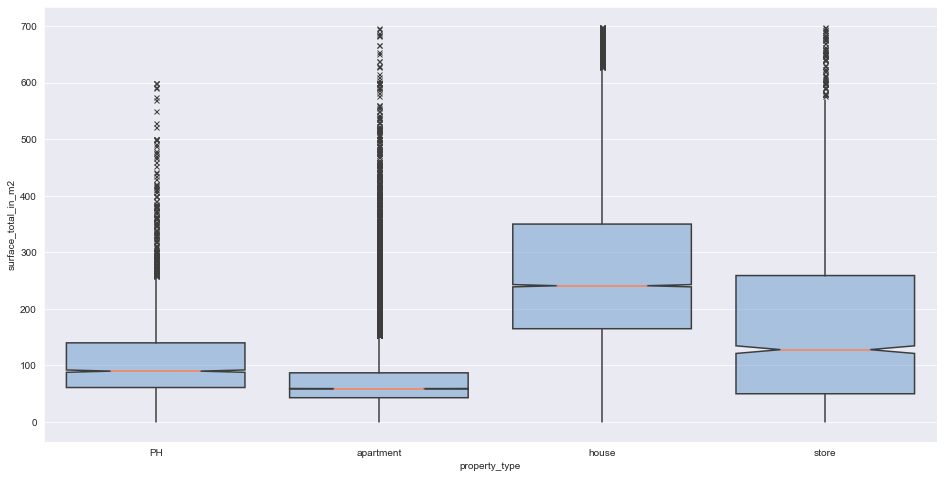

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(16, 8))
sns.boxplot(
    data=data, x="property_type", y=data[data['surface_total_in_m2'] < 700]['surface_total_in_m2'],
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)


# Top 10 StateName por propiedades

['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur', 'Córdoba', 'Santa Fe', 'Buenos Aires Costa Atlántica', 'Bs.As. G.B.A. Zona Oeste', 'Buenos Aires Interior', 'Río Negro', 'Neuquén']
Capital Federal                 32316
Bs.As. G.B.A. Zona Norte        25560
Bs.As. G.B.A. Zona Sur          13952
Córdoba                         12069
Santa Fe                        10172
Buenos Aires Costa Atlántica    10006
Bs.As. G.B.A. Zona Oeste         9322
Buenos Aires Interior            2291
Río Negro                         808
Neuquén                           733
Name: state_name, dtype: int64


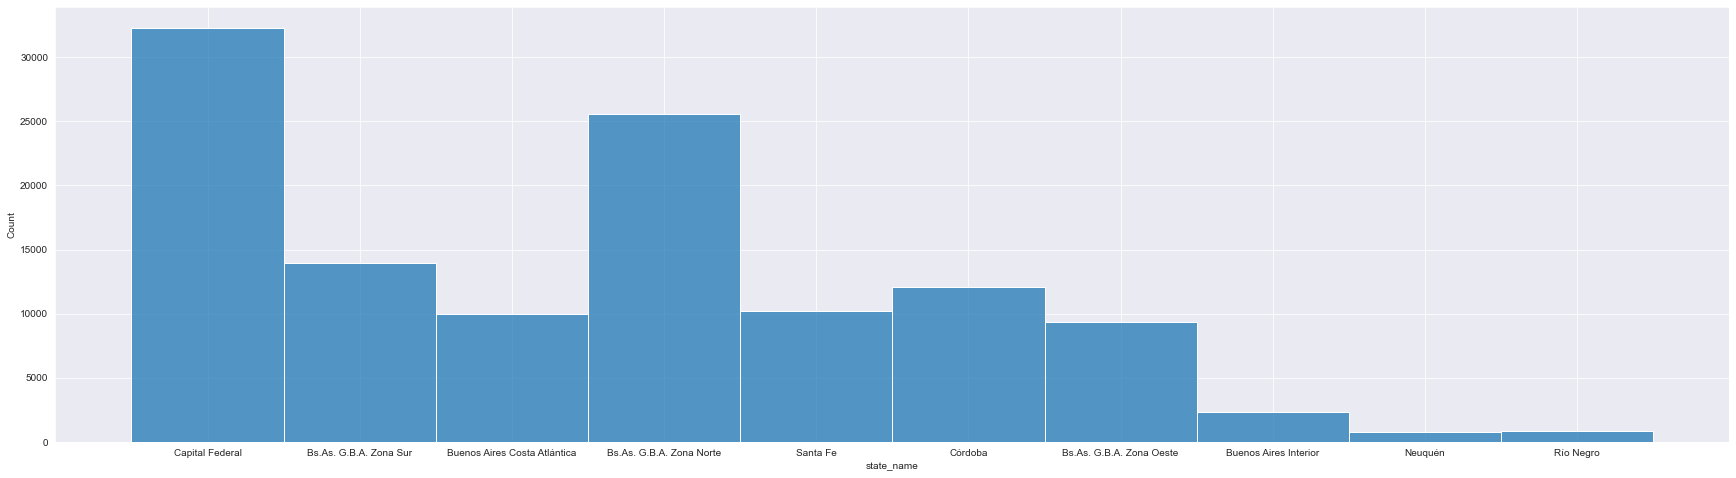

In [150]:
#Top 10 filtro para State Name grafico 10 provincias con mayor cantidad de propiedades
mask_100_state_name =data.state_name.value_counts().nlargest(10)

list=[]
for i in mask_100_state_name.items():
    list.append(i[0])
print(list)


mask_list=data.state_name.isin(list)

plt.figure(figsize=(30, 8))
sns.histplot(
    data=data[mask_list], x="state_name", stat='count'
)

print(data.state_name.value_counts().nlargest(10))
#data.state_name.unique()

<AxesSubplot:xlabel='property_type', ylabel='price_aprox_usd'>

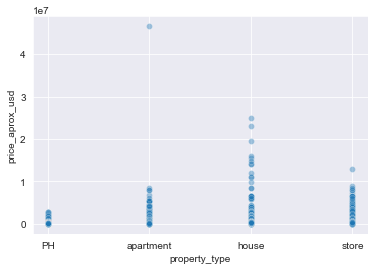

In [153]:
#Graficamos por property type y price_aprox_usd
#Pareceria haber outliers en Apartments > 4, houses > 2 y stores > 1
sns.scatterplot(data=data, x='property_type', y="price_aprox_usd", alpha=0.4)

<AxesSubplot:xlabel='property_type', ylabel='surface_total_in_m2'>

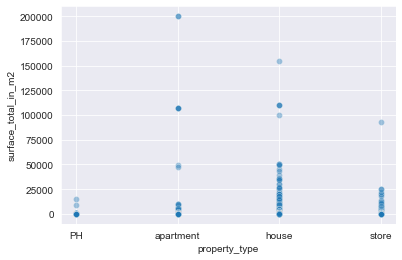

In [154]:
#Graficamos por property type y surface_total_in_m2
#Pareceria haber outliers en Apartments > 25000, houses > 100000 y stores > 75000
sns.scatterplot(data=data, x='property_type', y="surface_total_in_m2", alpha=0.4)

<AxesSubplot:xlabel='property_type', ylabel='surface_covered_in_m2'>

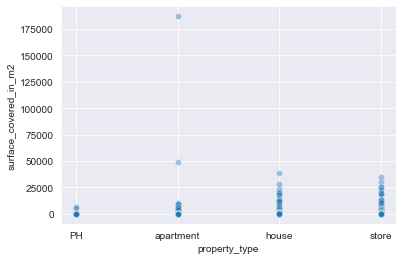

In [155]:
#Graficamos por property type y surface_covered_in_m2
#Pareceria haber outliers en Apartments > 50000
sns.scatterplot(data=data, x='property_type', y="surface_covered_in_m2", alpha=0.4)

# Correlacion entre Expensas, Superficie total y Precio por M2 (Capital Federal)

<AxesSubplot:xlabel='expenses', ylabel='price_aprox_usd'>

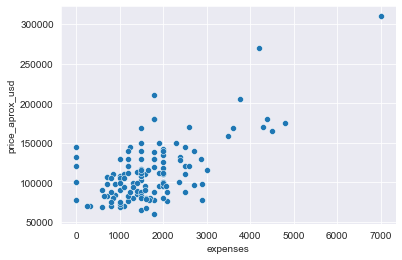

In [157]:
data_deptos_40=(data.surface_covered_in_m2==40)&(data.property_type=="apartment")&(data.state_name=="Capital Federal")
data[data_deptos_40]
sns.scatterplot(data=data[data_deptos_40],x="expenses",y="price_aprox_usd")

<AxesSubplot:xlabel='expenses', ylabel='price_aprox_usd'>

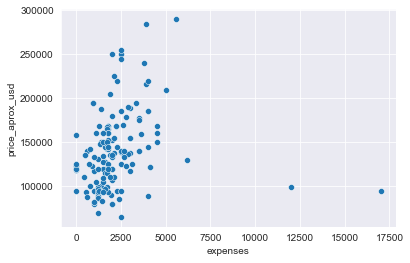

In [158]:
data_deptos_50=(data.surface_covered_in_m2==50)&(data.property_type=="apartment")&(data.state_name=="Capital Federal")
data[data_deptos_50]
sns.scatterplot(data=data[data_deptos_50],x="expenses",y="price_aprox_usd")

<AxesSubplot:xlabel='expenses', ylabel='price_aprox_usd'>

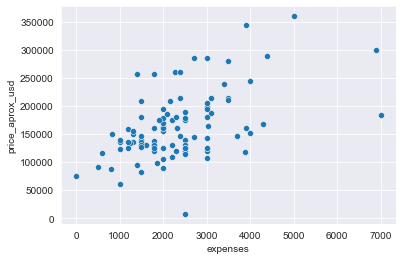

In [159]:
data_deptos_60=(data.surface_covered_in_m2==60)&(data.property_type=="apartment")&(data.state_name=="Capital Federal")
data[data_deptos_60]
sns.scatterplot(data=data[data_deptos_60],x="expenses",y="price_aprox_usd")

In [160]:
#SUMAR GRAFICOS ELEONORA DE AMBIENTES Y M2

In [156]:
#Prodiamos dropear las siguientes columnas porque no agregan valor
#image_thumbnail 
#properati_url